In [17]:
from tavily import TavilyClient, AsyncTavilyClient

from typing import List

In [18]:
from datetime import datetime
from pydantic import BaseModel, Field
from typing import Union
tavily_client = TavilyClient()


### State
class SearchQueriesParams(BaseModel):
    n_queries : int=Field(description="Number of queries to generate")
    
    queries: List[str] = Field(
        description="A list of strings representing the search queries to be executed.",
    )
    tavily_days: List[Union[int, None]] = Field(
        description="A list of integers representing the number of days to limit search results for each query (e.g., 7 for last week), or None for no time restriction. Each value corresponds to a query in the 'queries' list.",
    )
    tavily_topic: List[str] = Field(
        description="A list of strings indicating the type of search for each query: 'news' for time-sensitive queries or 'general' for unrestricted searches. Each value corresponds to a query in the 'queries' list.",
    )



In [19]:
from typing import TypedDict

In [20]:
class GraphState(TypedDict):
    news_summary : str
    question : str
    question_type : Union[str, str]
    generation : str
    web_search : Union[str, str] 
    search_queries_params : SearchQueriesParams
    documents : str #the concatenated list of documents text content (or search results)
    decission : str
    feedback : Union[None, str]
    iterations:int


In [21]:
from utils.chatbot_graph import app as chatbot_graph #QA Chatbot

In [22]:
from langgraph.graph import StateGraph, MessagesState, START

In [23]:
# remote_graph = RemoteGraph(graph_name, url=url)


In [24]:
builder = StateGraph(GraphState)

In [25]:
builder.add_node("child", chatbot_graph)

builder.add_edge(START, "child")

graph = builder.compile()


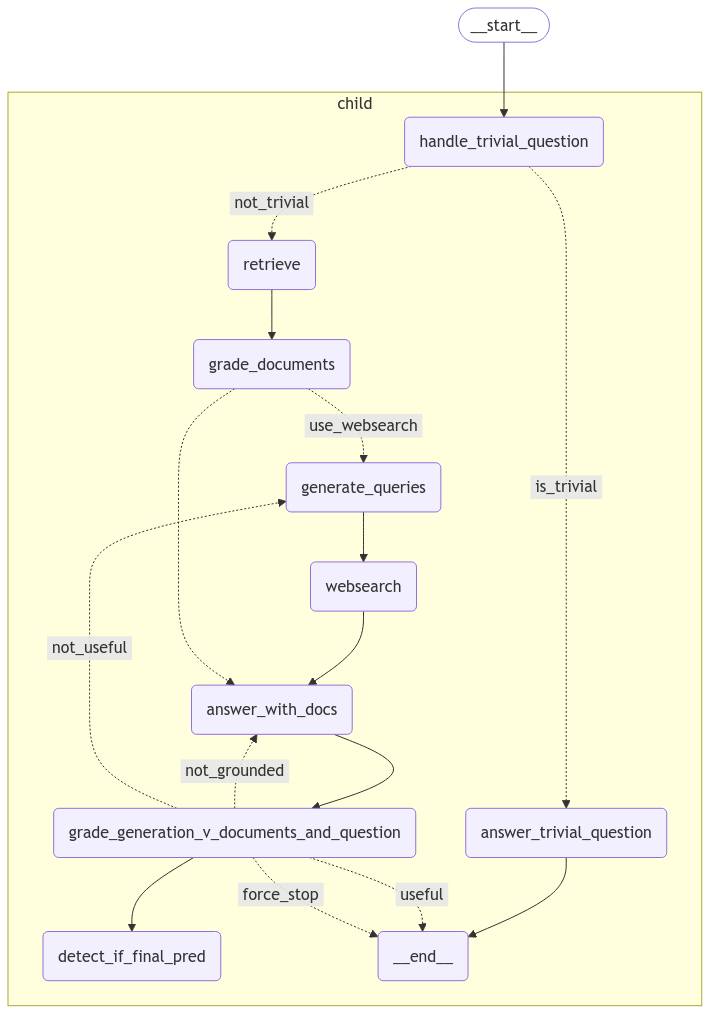

In [26]:
from IPython.display import Image

display(Image(graph.get_graph(xray=1).draw_mermaid_png(
)))

_________________

In [1]:
import time

In [28]:
type(time.time())

float

In [4]:
from langgraph.graph import END, StateGraph
from tavily import TavilyClient, AsyncTavilyClient
# tavily_async_client = AsyncTavilyClient()
from datetime import datetime
from pydantic import BaseModel, Field
from typing import Union, List, TypedDict
tavily_client = TavilyClient()
import time


### State
class SearchQueriesParams(BaseModel):
    n_queries : int=Field(description="Number of queries to generate")
    
    queries: List[str] = Field(
        description="A list of strings representing the search queries to be executed.",
    )
    tavily_days: List[Union[int, None]] = Field(
        description="A list of integers representing the number of days to limit search results for each query (e.g., 7 for last week), or None for no time restriction. Each value corresponds to a query in the 'queries' list.",
    )
    tavily_topic: List[str] = Field(
        description="A list of strings indicating the type of search for each query: 'news' for time-sensitive queries or 'general' for unrestricted searches. Each value corresponds to a query in the 'queries' list.",
    )


#we'll reference to this object very often to add new docs...etc
    
class GraphState(TypedDict):
    start_time:float
    news_summary : str
    question : str
    question_type : Union[str, str]
    generation : str
    web_search : Union[str, str] 
    search_queries_params : SearchQueriesParams
    documents : str #the concatenated list of documents text content (or search results)
    decission : str
    feedback : Union[None, str]
    iterations:int


In [5]:
from tts_variants import sync_tts

pygame 2.6.1 (SDL 2.28.4, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [6]:
from utils.chatbot_graph import app as chatbot_graph

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [9]:
import io
import threading
import numpy as np
import sounddevice as sd
from scipy.io.wavfile import write
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage

from openai import OpenAI

from elevenlabs import play, VoiceSettings
from elevenlabs.client import ElevenLabs

from langgraph.graph import StateGraph, MessagesState, END, START
import os
from dotenv import load_dotenv
load_dotenv()

# Initialize OpenAI client
openai_client = OpenAI()

# Initialize ElevenLabs client
elevenlabs_client = ElevenLabs(api_key=os.getenv("ELEVEN_API_KEY"))

def record_audio_until_stop(state):
    
    

    """Records audio from the microphone until Enter is pressed, then saves it to a .wav file."""
    
    audio_data = []  # List to store audio chunks
    recording = True  # Flag to control recording
    sample_rate = 16000 # (kHz) Adequate for human voice frequency

    def record_audio():
        """Continuously records audio until the recording flag is set to False."""
        nonlocal audio_data, recording
        with sd.InputStream(samplerate=sample_rate, channels=1, dtype='int16') as stream:
            print("Recording your instruction! ... Press Enter to stop recording.")
            while recording:
                audio_chunk, _ = stream.read(1024)  # Read audio data in chunks
                audio_data.append(audio_chunk)

    def stop_recording():
        """Waits for user input to stop the recording."""
        input()  # Wait for Enter key press
        nonlocal recording
        recording = False

    # Start recording in a separate thread
    recording_thread = threading.Thread(target=record_audio)
    recording_thread.start()

    # Start a thread to listen for the Enter key
    stop_thread = threading.Thread(target=stop_recording)
    stop_thread.start()

    # Wait for both threads to complete
    stop_thread.join()
    recording_thread.join()

    # Stack all audio chunks into a single NumPy array and write to file
    audio_data = np.concatenate(audio_data, axis=0)
    
    # Convert to WAV format in-memory
    audio_bytes = io.BytesIO()
    write(audio_bytes, sample_rate, audio_data)  # Use scipy's write function to save to BytesIO
    audio_bytes.seek(0)  # Go to the start of the BytesIO buffer
    audio_bytes.name = "audio.wav" # Set a filename for the in-memory file

    # Transcribe via Whisper
    transcription = openai_client.audio.transcriptions.create(
       model="whisper-1", 
       file=audio_bytes,
    )

    
    print(type(transcription))
    print(transcription)
    
    # Transcription(text="Hey, what's up?")

    
    # Print the transcription
    print("Here is the transcription:", transcription.text)

    # Write to messages 
    return {"question": transcription.text}

def play_audio(state):
    
    """Plays the audio response from the remote graph with ElevenLabs."""

    # Response from the agent 
    response = state['generation']

    # Prepare text by replacing ** with empty strings
    # These can cause unexpected behavior in ElevenLabs
    # cleaned_text = response.replace("**", "")
    
    # # Call text_to_speech API with turbo model for low latency
    # response = elevenlabs_client.text_to_speech.convert(
    #     voice_id="pNInz6obpgDQGcFmaJgB", # Adam pre-made voice
    #     output_format="mp3_22050_32",
    #     text=cleaned_text,
    #     model_id="eleven_turbo_v2_5", 
    #     voice_settings=VoiceSettings(
    #         stability=0.0,
    #         similarity_boost=1.0,
    #         style=0.0,
    #         use_speaker_boost=True,
    #     ),
    # )
    
    # # Play the audio back
    # play(response)
    
    sync_tts(response) #using openai instead of elevenlabs tts


def start_time_count(state):
    
    # state["start_time"] = time.time()
    return {"start_time":time.time()}
    
def show_output(state):
    
    start_time = state["start_time"]
    
    end_time = time.time()
    el = end_time-start_time
    
    print("Answerrr:", state["generation"])
    
    print("[*] INFERENCE TIME, ",el, " secs")

# Define parent graph
builder = StateGraph(GraphState)

# Add remote graph directly as a node
builder.add_node("audio_input", record_audio_until_stop)


builder.add_node("start_time_count", start_time_count)

builder.add_node("chatbot", chatbot_graph)
builder.add_node("show_output", show_output)

builder.add_node("audio_output", play_audio)


builder.add_edge(START, "audio_input")

builder.add_edge("audio_input", "start_time_count")

builder.add_edge("audio_input", "chatbot")
# builder.add_edge("start_time_count", "chatbot")


builder.add_edge("chatbot", "show_output")

builder.add_edge("show_output","audio_output")
# builder.add_edge("show_output", "audio_output")

builder.add_edge("audio_output",END)
graph = builder.compile()

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

KeyError: 'chatbot'

In [33]:
thread = {"configurable": {"thread_id":"1"}} #"recursion_limit":60

In [34]:
narrative_text = "Ready to know what happened this week? Let's dive in. First up, fitness enthusiasts are buzzing about high-intensity interval training, which promises to keep you burning calories long after your workout ends. Meanwhile, in the world of international affairs, Ukraine made headlines by using a naval drone to take down a Russian helicopter, marking a significant moment in their ongoing conflict. As Asia celebrated the arrival of 2025 with spectacular fireworks, Elon Musk stirred controversy in Germany by endorsing a far-right party, leading to a media shake-up. Across the Atlantic, Donald Trump surprised many by supporting Elon Musk and the H-1B visa program, causing ripples within the Republican Party. In entertainment, Lily-Rose Depp is making waves with her role in the new Nasratu film, while Trump mourns the loss of former U.S. President Jimmy Carter, who passed away at 100, leaving behind a legacy of peace and humanitarian work. Spain is facing unrest as public employees deal with frozen salaries and healthcare disruptions, while in Brazil, a tragic poisoning incident involving a Christmas cake is under investigation. Azerbaijan and Russia are at odds over a plane crash, with calls for an independent probe. In South Korea, a devastating plane crash claimed 179 lives, marking the worst air disaster in the country in decades. New York is reeling from a scandal involving prison brutality, prompting calls for justice and reform. The WHO's Tedros Adhanom Ghebreyesus narrowly escaped a bombing in Yemen, highlighting the ongoing conflict in the region. Tensions are also high between Venezuela and Argentina over accusations of terrorism, while Ukraine continues to fend off Russian aerial attacks. In Madrid, a graffiti artist faces a hefty fine for his street art spree. And in New York, a shocking video of prison violence has sparked outrage and investigations. Meanwhile, Russia's use of a ghost freight to bypass sanctions is raising alarms in the Baltic region. In China, a tragic incident involving a driver plowing into a crowd has sparked discussions on public mourning and censorship. Back in New York, the Guardian Angels are back on patrol in the subway after a horrific attack, aiming to boost public safety. Finally, Spain's Muface is in turmoil as major health insurers withdraw, leaving many civil servants without private coverage. As the year wraps up, these events remind us of the complexities and challenges facing our world today. Stay tuned for more updates.\n"

In [ ]:
response = elevenlabs_client.text_to_speech.convert(
        voice_id="9BWtsMINqrJLrRacOk9x", # Adam pre-made voice
        output_format="mp3_22050_32",
        text="although experts say there's no chance of deportation.",
        model_id="eleven_turbo_v2_5", 
        # voice_settings=VoiceSettings(
        #     stability=0.0,
        #     similarity_boost=1.0,
        #     style=0.0,
        #     use_speaker_boost=True,
        # ),
    )
    
    # Play the audio back
play(response)

In [20]:
type(response)

generator

In [1]:
from tts_variants import streamed_oai_response_tts, text_to_tts


pygame 2.6.1 (SDL 2.28.4, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
text_to_tts("hey what's up")

Queued sentence: hey what's up
Time taken to start playing audio clip: 0.4827702045440674 seconds


In [ ]:
text

In [35]:
from pprint import pprint
inputs = {"news_summary":narrative_text}
for output in graph.stream(inputs, thread):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
# pprint(value["generation"])

Recording your instruction! ... Press Enter to stop recording.
<class 'openai.types.audio.transcription.Transcription'>
Transcription(text='hey')
Here is the transcription: hey
'Finished running: audio_input:'
'Finished running: start_time_count:'


InvalidUpdateError: Expected node start_time to update at least one of ['start_time', 'news_summary', 'question', 'question_type', 'generation', 'web_search', 'search_queries_params', 'documents', 'decission', 'feedback', 'iterations'], got {'streaming_avaiable': True, 'response_stream': <generator object BaseChatModel.stream at 0x000002B1989DB6E0>}

In [1]:
from langchain_openai import Ch

In [2]:
llm = ChatOpenAI(name="gpt4o-mini")

In [27]:
model = ChatOpenAI(
            model="gpt-3.5-turbo-0125")
            # temperature = 0)

In [30]:
model.invoke("hi", max_tokens=150, temperature=0.1)

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-98bfca38-c08b-4fb3-8372-181f0a50f770-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [28]:
model.invoke("if i tell you im spanish, do you believe me?")

AIMessage(content='As an AI, I do not have the ability to determine whether or not someone is telling the truth about their identity. I can only respond based on the information provided to me. If you say you are Spanish, I will take your word for it.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 19, 'total_tokens': 71, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-7d5743fc-4ece-45ec-abde-c81a444e4b0c-0', usage_metadata={'input_tokens': 19, 'output_tokens': 52, 'total_tokens': 71, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [5]:
llm.invoke("who's donal trump", max_tokens=150)

AIMessage(content='Donald Trump is a former President of the United States, businessman, and television personality. He served as the 45th President of the United States from 2017 to 2021. Trump is known for his controversial statements and policies during his time in office.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 12, 'total_tokens': 66, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-3ae07d82-9106-48f2-a10e-bb741f97a33b-0', usage_metadata={'input_tokens': 12, 'output_tokens': 54, 'total_tokens': 66, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [31]:
model = ChatOpenAI(
            model="gpt-4",
            temperature = 0,
            model_kwargs={"response_format": {"type": "json_object"}})

model.invoke("json of rpg players")

BadRequestError: Error code: 400 - {'error': {'message': "Invalid parameter: 'response_format' of type 'json_object' is not supported with this model.", 'type': 'invalid_request_error', 'param': 'response_format', 'code': None}}

In [35]:
model = ChatOpenAI(
            model="gpt-4-turbo-2024-04-09",
            temperature = 0,
            model_kwargs={"response_format": {"type": "json_object"}})

model.invoke("json of rpg players")

AIMessage(content='\n{\n  "players": [\n    {\n      "id": 1,\n      "name": "Aragorn",\n      "class": "Warrior",\n      "level": 20,\n      "stats": {\n        "strength": 18,\n        "dexterity": 12,\n        "constitution": 15,\n        "intelligence": 10,\n        "wisdom": 13,\n        "charisma": 14\n      },\n      "equipment": {\n        "weapon": "Anduril",\n        "armor": "Royal Armor",\n        "accessories": ["Elven Cloak", "Ring of Barahir"]\n      },\n      "skills": ["Sword Fighting", "Leadership", "Survival"]\n    },\n    {\n      "id": 2,\n      "name": "Gandalf",\n      "class": "Wizard",\n      "level": 20,\n      "stats": {\n        "strength": 10,\n        "dexterity": 14,\n        "constitution": 12,\n        "intelligence": 18,\n        "wisdom": 17,\n        "charisma": 13\n      },\n      "equipment": {\n        "weapon": "Glamdring",\n        "armor": "Wizard\'s Robe",\n        "accessories": ["Wizard\'s Staff", "White Hat"]\n      },\n      "skills": ["Sp

________________

In [13]:
from typing import TypedDict, Union, List
from pydantic import BaseModel, Field

class SearchQueriesParams(BaseModel):
    n_queries : int=Field(description="Number of queries to generate")
    
    queries: List[str] = Field(
        description="A list of strings representing the search queries to be executed.",
    )
    tavily_days: List[Union[int, None]] = Field(
        description="A list of integers representing the number of days to limit search results for each query (e.g., 7 for last week), or None for no time restriction. Each value corresponds to a query in the 'queries' list.",
    )
    tavily_topic: List[str] = Field(
        description="A list of strings indicating the type of search for each query: 'news' for time-sensitive queries or 'general' for unrestricted searches. Each value corresponds to a query in the 'queries' list.",
    )


In [14]:
class GraphState(TypedDict):
    news_summary : str
    question : str
    question_type : Union[str, str]
    generation : str
    web_search : Union[str, str] 
    search_queries_params : SearchQueriesParams
    documents : str #the concatenated list of documents text content (or search results)
    decission : str
    feedback : Union[None, str]
    iterations:int


In [16]:
from utils.chatbot_graph import app as chatbot_graph

In [17]:
import io
import threading
import numpy as np
import sounddevice as sd
from scipy.io.wavfile import write
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage

from openai import OpenAI

from elevenlabs import play, VoiceSettings
from elevenlabs.client import ElevenLabs

from langgraph.graph import StateGraph, MessagesState, END, START
import os
from dotenv import load_dotenv
load_dotenv()

# Initialize OpenAI client
openai_client = OpenAI()

# Initialize ElevenLabs client
elevenlabs_client = ElevenLabs(api_key=os.getenv("ELEVEN_API_KEY"))

def record_audio_until_stop(state):

    """Records audio from the microphone until Enter is pressed, then saves it to a .wav file."""
    
    audio_data = []  # List to store audio chunks
    recording = True  # Flag to control recording
    sample_rate = 16000 # (kHz) Adequate for human voice frequency

    def record_audio():
        """Continuously records audio until the recording flag is set to False."""
        nonlocal audio_data, recording
        with sd.InputStream(samplerate=sample_rate, channels=1, dtype='int16') as stream:
            print("Recording your instruction! ... Press Enter to stop recording.")
            while recording:
                audio_chunk, _ = stream.read(1024)  # Read audio data in chunks
                audio_data.append(audio_chunk)

    def stop_recording():
        """Waits for user input to stop the recording."""
        input()  # Wait for Enter key press
        nonlocal recording
        recording = False

    # Start recording in a separate thread
    recording_thread = threading.Thread(target=record_audio)
    recording_thread.start()

    # Start a thread to listen for the Enter key
    stop_thread = threading.Thread(target=stop_recording)
    stop_thread.start()

    # Wait for both threads to complete
    stop_thread.join()
    recording_thread.join()

    # Stack all audio chunks into a single NumPy array and write to file
    audio_data = np.concatenate(audio_data, axis=0)
    
    # Convert to WAV format in-memory
    audio_bytes = io.BytesIO()
    write(audio_bytes, sample_rate, audio_data)  # Use scipy's write function to save to BytesIO
    audio_bytes.seek(0)  # Go to the start of the BytesIO buffer
    audio_bytes.name = "audio.wav" # Set a filename for the in-memory file

    # Transcribe via Whisper
    transcription = openai_client.audio.transcriptions.create(
       model="whisper-1", 
       file=audio_bytes,
    )

    
    print(type(transcription))
    print(transcription)
    
    # Transcription(text="Hey, what's up?")

    
    # Print the transcription
    print("Here is the transcription:", transcription.text)

    # Write to messages 
    return {"question": transcription.text}

def play_audio(state):
    
    """Plays the audio response from the remote graph with ElevenLabs."""

    # Response from the agent 
    response = state['generation']

    # Prepare text by replacing ** with empty strings
    # These can cause unexpected behavior in ElevenLabs
    cleaned_text = response.replace("**", "")
    
    # Call text_to_speech API with turbo model for low latency
    response = elevenlabs_client.text_to_speech.convert(
        voice_id="pNInz6obpgDQGcFmaJgB", # Adam pre-made voice
        output_format="mp3_22050_32",
        text=cleaned_text,
        model_id="eleven_turbo_v2_5", 
        voice_settings=VoiceSettings(
            stability=0.0,
            similarity_boost=1.0,
            style=0.0,
            use_speaker_boost=True,
        ),
    )
    
    # Play the audio back
    play(response)


def show_output(state):
    
    print("Answerrr:", state["generation"])

# Define parent graph
builder = StateGraph(GraphState, input=GraphState, output=GraphState)

# Add remote graph directly as a node
builder.add_node("audio_input", record_audio_until_stop)
builder.add_node("chatbot", chatbot_graph)
builder.add_node("show_output", show_output)

builder.add_node("audio_output", play_audio)


builder.add_edge(START, "audio_input")
builder.add_edge("audio_input", "chatbot")

builder.add_edge("chatbot", "show_output")

# builder.add_edge("chatbot","audio_output")
builder.add_edge("show_output", "audio_output")

builder.add_edge("audio_output",END)
graph = builder.compile()

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

KeyError: 'chatbot'

In [1]:
from langchain_openai import ChatOpenAI

In [14]:
model = ChatOpenAI(model="gpt-4-turbo")

In [15]:
model.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_1a5512f3de', 'finish_reason': 'stop', 'logprobs': None}, id='run-b264073a-8b67-413e-b266-bac6efa711cf-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [12]:
model = ChatOpenAI(model="gpt-3.5-turbo")

In [13]:

model.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-aad7f3c0-95ef-4553-8af1-7ef0bb770af9-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})